# Example 3: Analysis Involving Multiple Tracers
Here we extend the analysis of a single tracer species (see Examples 1 and 2) to the case of two tracer species observed simultaneously in an observation well.

In [1]:
import PyTracerLab.model as ism
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Load (Synthetic) Observation Data
See Example 5 on how this data is generated.

In [2]:
# load input series
# this would be the tracer concentration in precipitation or recharge in a
# practical problem
file_name = "example_input_series_2tracer.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float, float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
input_series = np.array([[row[1], row[2]] for row in data], dtype=float)

# load observation series
# this would be the measured tracer concentration in groudnwater in a
# practical problem
file_name = "example_observation_series_2tracer.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float, float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
obs_series = np.array([[row[1], row[2]] for row in data], dtype=float)

# load full system output series
# this would be the true tracer concentration in groudnwater in a practical
# problem; this is not available in practice
file_name = "example_output_series_2tracer.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float, float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
output_series = np.array([[row[1], row[2]] for row in data], dtype=float)

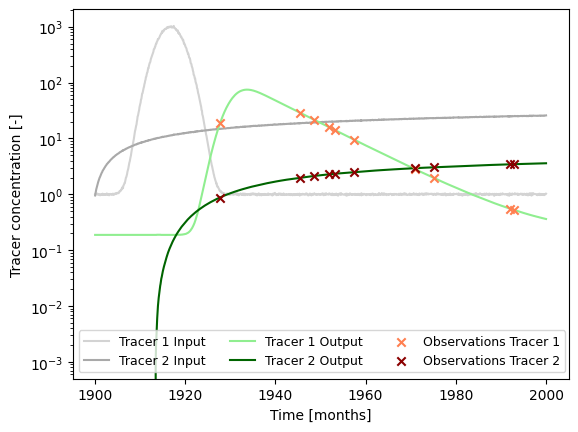

In [3]:
### plot input series, output series, and observations

# get observation timesteps
timesteps = [t.year + t.month / 12.0 for t in timestamps]

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series[:, 0],
    label="Tracer 1 Input",
    c="lightgrey"
)
ax.plot(
    timesteps,
    input_series[:, 1],
    label="Tracer 2 Input",
    c="darkgrey"
)

# plot output series
ax.plot(
    timesteps,
    output_series[:, 0],
    label="Tracer 1 Output",
    c="lightgreen"
)
ax.plot(
    timesteps,
    output_series[:, 1],
    label="Tracer 2 Output",
    c="darkgreen"
)

# plot observations
ax.scatter(
    timesteps,
    obs_series[:, 0],
    label="Observations Tracer 1",
    color="coral",
    marker="x",
    zorder=10
)
ax.scatter(
    timesteps,
    obs_series[:, 1],
    label="Observations Tracer 2",
    color="darkred",
    marker="x",
    zorder=10
)

ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend(ncol=3, fontsize=9)
ax.set_yscale("log")
plt.show()

## 2. Model Setup

In [4]:
t_half = 12.32 * 12.0 # tritium
lambda_1 = np.log(2.0) / t_half

t_half = 10.73 * 12.0 # krypton 85
lambda_2 = np.log(2.0) / t_half

### define model (we do not use the same structure / units as the true model)
# time step is 1 month
m = ism.Model(
    dt=1.0,
    lambda_=[lambda_1, lambda_2],
    input_series=input_series,
    target_series=obs_series,
    steady_state_input=[1., 0.], # this is the true value
    n_warmup_half_lives=10
)

# add an exponential-piston-flow unit
# define the initial model parameters for inference
epm_mtt_init = 12 * 40 # 20 years
epm_eta_init = 1.9 # the true value is 1.5
m.add_unit(
    ism.EPMUnit(mtt=epm_mtt_init, eta=epm_eta_init),
    fraction=1., # true value would be 0.8 (with 0.2 PM)
    bounds=[(1.0, 12.0 * 100.), (1.0, 3.0)],
    prefix="epm"
)

## 3. Model Simulation for Different Mean Travel Times
### 3.1 Conventional Tracer-Tracer Analysis
We finally create something known as a tracer-tracer plot (in german there is a term for this: "Harfendiagramm" or "harp diagram" as it is visually similar to a harp).

The purpose of those diagrams is more to interpret and understand tracer observations rather than calibrate model parameters. Typically, a model is considered with just one unit (e.g., an exponential unit). Then, the model is simulated with many different parameter values for the mean travel time. With each setting, the model is simulated, and the results are stored.

Ultimately, we obtain a 3D array of data with the following axes:
- the two tracers
- all considered mean travel times
- all time steps in the input time series of the two tracers

In the tracer-tracer plot, we then plot a subset of this 3D array. This subset is a 2D array and has the following axes:
- the two tracers
- all considered mean travel times

We get this subset by "slicing" the original 3D array at a certain time step or date. This date is typically chosen to be a date where an observation is available. The resulting diagram is therefore dependent on the reference date we select as a starting point (i.e., it does make a difference if we consider a water parcel with a residence time of 10 years recharging in the year 2025 or in the year 1983 as those periods can be associated with completely different input concentrations). Points on the diagram are sometimes annotated with their input date or travel time; we subsequently color the points according to their travel time.

In [5]:
# Define range of mean travel times to consider
mtt_range = np.linspace(12 * 5, 12 * 80, 21)

# Create empty array of results
results = np.zeros((2, len(mtt_range), len(input_series)))

# Iterate over mean travel times
for i, mtt in enumerate(mtt_range):
    m.set_param(key="epm.mtt", value=mtt)
    sim = m.simulate()
    results[0, i, :] = sim[:, 0].flatten()
    results[1, i, :] = sim[:, 1].flatten()


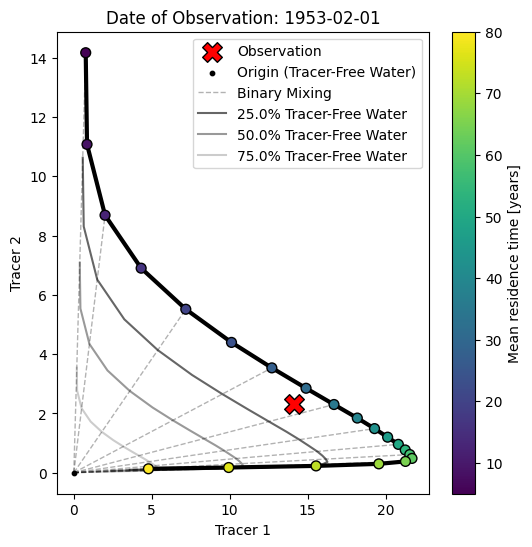

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Get indices of time series that have observations
obs_indices = np.arange(len(timestamps))[~np.isnan(obs_series).any(axis=1)]

# select index of observation date
idx_select = 4

# plot the line connecting the points of different mean travel times
ax.plot(
    results[0, :, obs_indices[idx_select]],
    results[1, :, obs_indices[idx_select]],
    c="black",
    lw=3.
)
# plot the points of different mean travel times and color them by mean
# travel time
im = ax.scatter(
    results[0, :, obs_indices[idx_select]],
    results[1, :, obs_indices[idx_select]],
    c=mtt_range / 12.,
    edgecolor="k",
    s=50,
    zorder=10
)
# plot the observation
ax.scatter(
    obs_series[obs_indices[idx_select], 0],
    obs_series[obs_indices[idx_select], 1],
    c="r",
    edgecolor="k",
    marker="X",
    zorder=10,
    s=200,
    label="Observation"
)
# plot the origin point
ax.scatter(
    [0.],
    [0.],
    c="k",
    edgecolor="k",
    marker="o",
    zorder=10,
    s=10,
    label="Origin (Tracer-Free Water)"
)

# plot straight lines from the origin to the points representing the different
# mean travel times
stepper = 2 # plot line from origin to every stepper point
points_idx = [i for i in range(len(mtt_range))][::stepper]
for i in points_idx:
    label = None
    if i == points_idx[0]:
        label = "Binary Mixing"
    ax.plot(
        [0., results[0, i, obs_indices[idx_select]]],
        [0., results[1, i, obs_indices[idx_select]]],
        c="k",
        lw=1.,
        alpha=0.3,
        ls="--",
        label=label
    )

# plot path between points representing the different mean travel times but
# multiplied by a range of dilution factors
percent_tracer_free = [.75, .5, .25]
for p in percent_tracer_free:
    ax.plot(
        results[0, :, obs_indices[idx_select]] * p,
        results[1, :, obs_indices[idx_select]] * p,
        c="k",
        lw=1.5,
        alpha=0.8 * p,
        label=f"{(1-p)*100}% Tracer-Free Water"
    )

plt.colorbar(im, ax=ax, label="Mean residence time [years]")
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("Tracer 1")
ax.set_ylabel("Tracer 2")
ax.legend()
# include observation date / diagram date as title
ax.set_title(f"Date of Observation: {timestamps[obs_indices[idx_select]].date()}")
plt.show()

### 3.2 Bringing the Analysis to Another Dimension
Here we re-use the results from before for the different mean travel times. But instead of plotting the trajectory of the tracer concentrations valid for a single observation date as before, we plot this diagram for *all* possible observation dates. Because we then have an additional axis or dimension in the data, we need to create a 3D-plot.

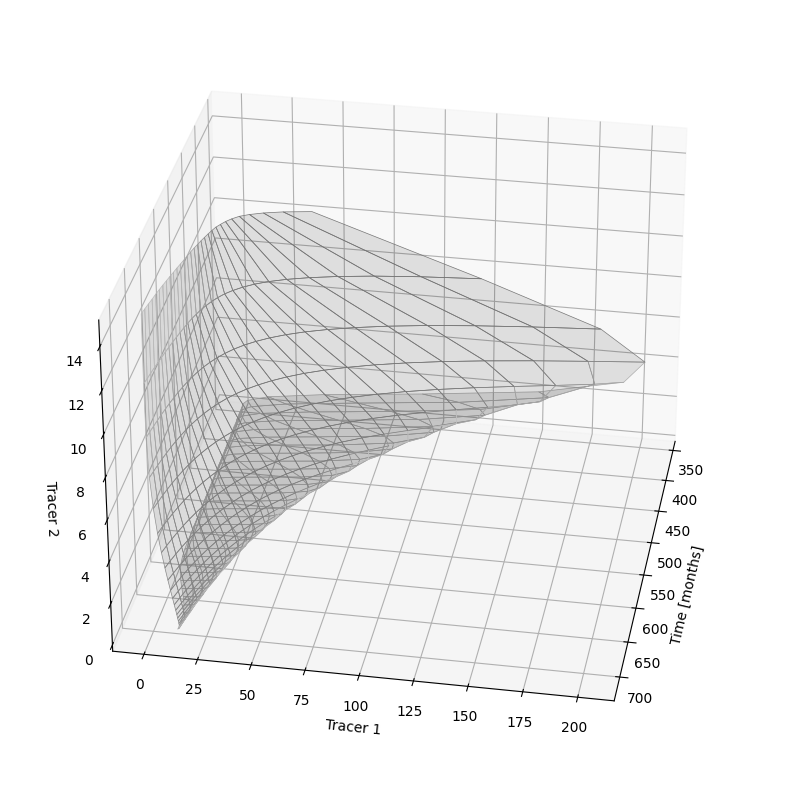

In [7]:
# make a 3d plot with a combination of tracer-tracer plots at all sample dates
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

start = 12 * 30
stop = 12 * 60
stepper = 12
time_ = [i for i in range(results.shape[2])][start:stop:stepper]
for i in range(len(time_) - 1):
    ax.fill_between(
        x1=[time_[i]],
        y1=results[0, :, time_[i]],
        z1=results[1, :, time_[i]],
        x2=[time_[i+1]],
        y2=results[0, :, time_[i+1]],
        z2=results[1, :, time_[i+1]],
        facecolors="k",
        edgecolors="lightgrey",
        linewidth=0.5,
        alpha=0.1
    )

ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer 1")
ax.set_zlabel("Tracer 2")

# rotate 3d plot
ax.view_init(30, 10)